# Guidance

This tutorial demonstrates how to perform guidance with a pre-trained diffusion model.

In [1]:
# !git clone --depth 1 --single-branch https://github.com/openai/guided-diffusion

In [2]:
import io
import requests
import sys
import torch

sys.path.append("guided-diffusion")

from PIL import Image
from torchvision.transforms.functional import to_pil_image, to_tensor
from torchvision.utils import make_grid

from azula.guidance import DiffPIRDenoiser, DPSSampler, MMPSDenoiser, PGDMSampler, TMPDenoiser
from azula.plugins import adm
from azula.sample import DDIMSampler

device = "cuda"

In [3]:
_ = torch.manual_seed(42)

In [4]:
def preprocess(x):
    return 2 * x - 1

In [5]:
def postprocess(x):
    return torch.clip((x + 1) / 2, min=0, max=1)

## Pre-trained diffusion model

In [6]:
denoiser = adm.load_model("imagenet_256x256").to(device)
denoiser = denoiser.requires_grad_(False)  # reduce memory overhead

Loading from /home/frozet/.cache/azula/hub/https.openaipublic.blob.core.windows.net.diffusion.jul-2021.256x256_diffusion_uncond.pt


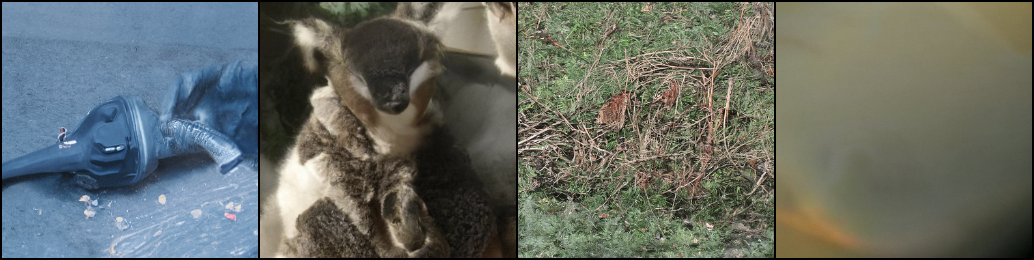

In [7]:
sampler = DDIMSampler(denoiser, steps=64).to(device)

x1 = sampler.init((4, 3, 256, 256))
x0 = sampler(x1)

to_pil_image(make_grid(postprocess(x0)))

## Measurement

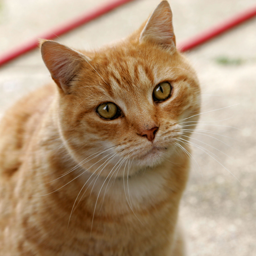

In [8]:
image = requests.get("https://upload.wikimedia.org/wikipedia/commons/3/3a/Cat03.jpg", headers={"User-Agent": "Azula"}).content
image = io.BytesIO(image)
image = Image.open(image).convert("RGB")
image = image.crop((0, 0, min(image.size), min(image.size))).resize((256, 256))
image

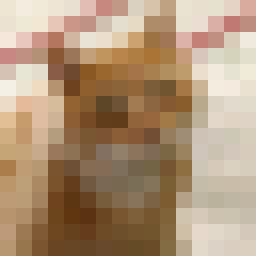

In [9]:
x = preprocess(to_tensor(image)).to(device)


def A(x):
    return torch.nn.functional.interpolate(x, (16, 16), mode="bicubic", antialias=True).flatten(-3)


def A_inv(y):
    return torch.nn.functional.interpolate(
        y.unflatten(-1, (3, 16, 16)), (256, 256), mode="nearest"
    )


sigma_y = 0.01

y = A(x.unsqueeze(0))
y = y + sigma_y * torch.randn_like(y)

to_pil_image(make_grid(postprocess(A_inv(y))))

## Diffusion Posterior Sampling (DPS)

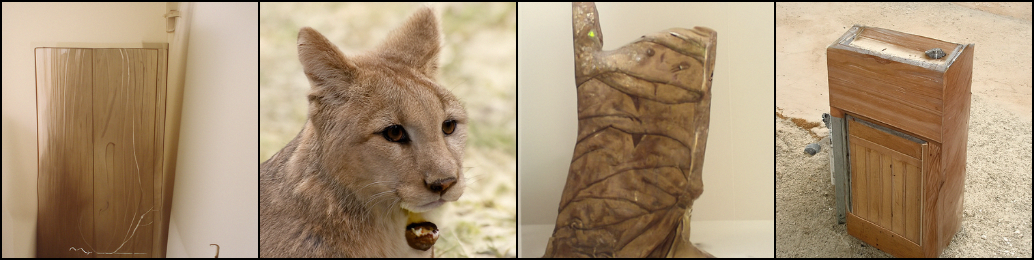

In [10]:
cond_sampler = DPSSampler(denoiser, y=y, A=A, steps=256).to(device)

x1 = cond_sampler.init((4, 3, 256, 256))
x0 = cond_sampler(x1)

to_pil_image(make_grid(postprocess(x0)))

## Pseudo-inverse Guided Diffusion Model (PGDM)

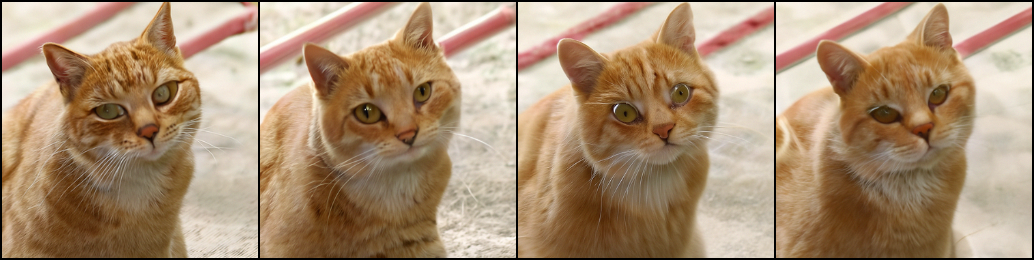

In [11]:
cond_sampler = PGDMSampler(denoiser, y=y, A=A, A_inv=A_inv, steps=64, eta=1.0).to(device)

x1 = cond_sampler.init((4, 3, 256, 256))
x0 = cond_sampler(x1)

to_pil_image(make_grid(postprocess(x0)))

## Diffusion Plug-and-Play Image Restoration (DiffPIR)

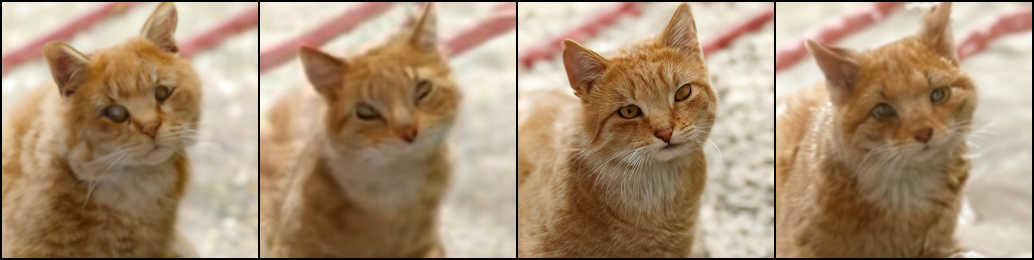

In [12]:
cond_denoiser = DiffPIRDenoiser(denoiser, y=y, A=A, var_y=sigma_y**2, iterations=1)
cond_sampler = DDIMSampler(cond_denoiser, steps=64, eta=1.0).to(device)

x1 = cond_sampler.init((4, 3, 256, 256))
x0 = cond_sampler(x1)

to_pil_image(make_grid(postprocess(x0)))

## Tweedie Moment Projected Diffusion (TMPD)

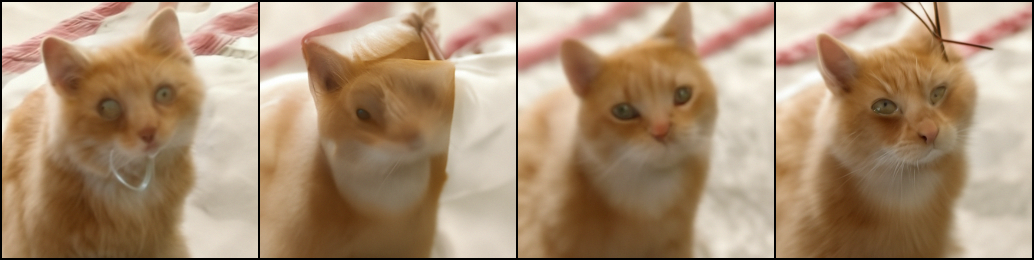

In [13]:
cond_denoiser = TMPDenoiser(denoiser, y=y, A=A, var_y=sigma_y**2)
cond_sampler = DDIMSampler(cond_denoiser, steps=64, eta=1.0).to(device)

x1 = cond_sampler.init((4, 3, 256, 256))
x0 = cond_sampler(x1)

to_pil_image(make_grid(postprocess(x0)))

## Moment Matching Posterior Sampling (MMPS)

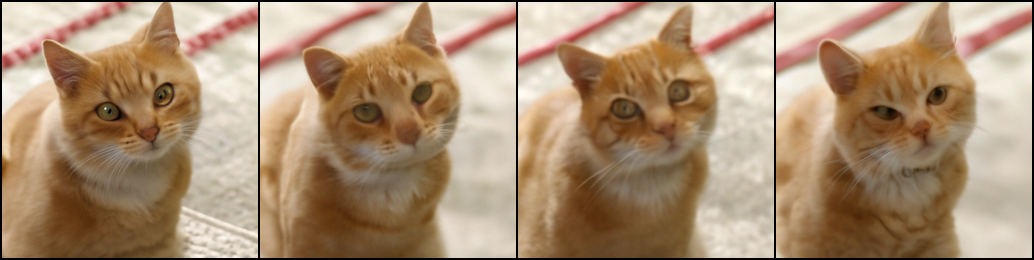

In [14]:
cond_denoiser = MMPSDenoiser(denoiser, y=y, A=A, var_y=sigma_y**2, iterations=3)
cond_sampler = DDIMSampler(cond_denoiser, steps=64, eta=1.0).to(device)

x1 = cond_sampler.init((4, 3, 256, 256))
x0 = cond_sampler(x1)

to_pil_image(make_grid(postprocess(x0)))